# **Ouroboros EEG-fMRI: Predicting EEG activity from fMRI activity and vice versa**

#### Version: 22nd August 2022

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

==============================================================================================

This project is presented through five Notebooks:

*01: Data Analysis*

*02: Classification*

*03: Regression on fMRI data*

***04: Regression on EEG data***

*05: Results*

==============================================================================================

### Notebook 04

# **Regression on EEG data**

## **1. Introduction to Regression on EEG data**

### 1.1 Objective

The objective of this project is to address the general question: **Can we train machine learning models to predict EEG activity from fMRI activity, and vice versa?** In this Notebook, we adress the second part of this question: predicting fMRI activity from EEG activity. 

Specifically, for each subject, we will try to predict the **fMRI BOLD signal** obtained for all the voxels of the brain, using the different **EEG frequency bands** extracted by the authors of the study. Some voxels may be more predictable than others by the EEG frequency bands. Therefore, we would like to know if the information obtained from EEG data is sufficient to predict the fMRI activity, but we are also interested in the **predictability map**, i.e. we would like to know, for example, if voxels from a particular brain region are more predictable than voxels from another brain region. 

### 1.2 Models

We will use several regression models and fine-tune their hyperparameters when relevant: **linear regression**, **regression with Huber loss**, **Ridge regression**, **Lasso regression**. For the fine-tuning, we will use a grid search approach, and store the test score as well as the value of the best hyperparameter found. For the fMRI data, we will use the dataset with the original voxel size. The baseline will be a model that predicts the mean value from the train set. 

### 1.3 Data import

Here we import the **EEG dataset** and the **preprocessed fMRI dataset**. For the latter, we store the data in dictionaries. 

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define the preprocessed data path. 
preprocessed_data_path = '../ouroboros_eeg-fmri_preprocessed_data/'

# Define the results path. If empty, the results will be saved in the current directory. 
results_path = ''

In [3]:
# Define the list of subjects. 
subjects = []

for subject_index in range(18):
    if subject_index < 9:
        subjects.append('sub-0' + str(subject_index + 1))
    else:
        subjects.append('sub-' + str(subject_index + 1))

print(subjects)

['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18']


In [4]:
# Load the EEG data. 
with open(preprocessed_data_path + 'predictors_EEG.p', 'rb') as file:
    predictors_EEG = pickle.load(file)

In [5]:
# Load the fMRI data, and store the data in dictionaries. 
predictors_fMRI = dict()
predictors_fMRI_r2 = dict()
predictors_fMRI_r3 = dict()

# Iterate through all subjects. 
counter = 1
for subject_index in subjects:
    
    # Display current step. 
    print('Starting subject ' + str(counter) + ' / ' + str(len(subjects)))
    
    # Load fMRI data with the original voxel size. 
    with np.load(preprocessed_data_path + 'predictors_fMRI.npz', allow_pickle = False) as npz_file:
        predictors_fMRI[subject_index] = npz_file['sub_' + str(counter)]
    
    # Load fMRI data with the voxel size rescaling by a factor 2. 
    with np.load(preprocessed_data_path + 'predictors_fMRI_r2.npz', allow_pickle = False) as npz_file:
        predictors_fMRI_r2[subject_index] = npz_file['sub_' + str(counter)]
        
    # Load fMRI data with the voxel size rescaling by a factor 3. 
    with np.load(preprocessed_data_path + 'predictors_fMRI_r3.npz', allow_pickle = False) as npz_file:
        predictors_fMRI_r3[subject_index] = npz_file['sub_' + str(counter)]
        
    # Increment. 
    counter += 1

Starting subject 1 / 18
Starting subject 2 / 18
Starting subject 3 / 18
Starting subject 4 / 18
Starting subject 5 / 18
Starting subject 6 / 18
Starting subject 7 / 18
Starting subject 8 / 18
Starting subject 9 / 18
Starting subject 10 / 18
Starting subject 11 / 18
Starting subject 12 / 18
Starting subject 13 / 18
Starting subject 14 / 18
Starting subject 15 / 18
Starting subject 16 / 18
Starting subject 17 / 18
Starting subject 18 / 18


In [6]:
# Determine the proportion of the test set for the regression models. 
test_set_proportion = 0.2

## **2. Preliminary steps**

### **2.1 Define functions**

In the following cells, we define a series of **functions to run regression models and display the results**. 

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

In [8]:
# Define the Mean Squared Error function. 
def MSE(y, y_pred):
    return np.mean(np.square(y - y_pred))

In [9]:
# Define the Mean Absolute Error function. 
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [10]:
# Define the Residual Sum of Squares function. 
def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))

In [11]:
# Define a function to run a regression model. 
def regression_model(Linear_Model, X_tr, X_te, y_tr, y_te, display_results = True, return_rank = False):
    
    # Fit the regression model and compute predictions. 
    lm = Linear_Model # LinearRegression(), HuberRegressor(), Ridge(), Lasso()
    lm.fit(X_tr, y_tr)
    y_pred_lm = lm.predict(X_te)
    
    # Compute the MSE, MAE and RSS measures. 
    mse_lm = MSE(y_te, y_pred_lm)
    mae_lm = MAE(y_te, y_pred_lm)
    rss_lm = RSS(y_te, y_pred_lm)
    if display_results == True:
        print('MSE:', mse_lm)
        print('MAE:', mae_lm)
        print('RSS:', rss_lm)

    # Compute the R^2 measure. 
    r2_lm = 1 - (rss_lm / rss_baseline)
    if display_results == True:
        print('R^2: ' + str(r2_lm))
        
    # Retrieve the rank. 
    if return_rank == True:
        rank = lm.rank_
    else:
        rank = None
    
    return y_pred_lm, mse_lm, mae_lm, rss_lm, r2_lm, lm.coef_, rank

In [12]:
# Define a function to fine-tune a Ridge or Lasso regression. 
def fine_tune_ridge_or_lasso(Linear_Model, X_tr, X_te, y_tr, y_te, alpha_values):
    
    # Create a list to store the results. 
    gs_results = []
    counter = 0

    # Fine-tune the regression model with a grid search. 
    for alpha in alpha_values:
        
        # Display step. 
        print('Starting step ' + str(counter) + ' / ' + str(len(alpha_values)))
        
        # Iterate. 
        for run_idx in range(5):
            
            # Create Ridge or Lasso regression. 
            lm = Linear_Model(alpha = alpha, max_iter = 20)

            # Split into train / valid sets. 
            X_tr2, X_va, y_tr2, y_va = train_test_split(
                X_tr, y_tr, test_size = 0.2, random_state = run_idx)

            # Fit the model. 
            lm.fit(X_tr2, y_tr2)

            # Save alpha value and model performance on train and validaton sets. 
            gs_results.append({
                'alpha': alpha,
                'train_mse': MSE(y_tr2, lm.predict(X_tr2)),
                'valid_mse': MSE(y_va, lm.predict(X_va)),
            })
            
        # Increment. 
        counter += 1
            
    return gs_results

In [13]:
# Define a function to display the results of the Ridge or Lasso regression fine-tuning. 
def display_ridge_or_lasso_fine_tuning(gs_results, alpha_values):
    
    # Convert results to DataFrame. 
    gs_results = pd.DataFrame(gs_results)

    # Group results by alpha value. 
    grouped = gs_results.groupby('alpha')

    # Compute train / valid mean scores with std. 
    mean_tr = grouped.train_mse.mean()
    mean_va = grouped.valid_mse.mean()
    std_tr = grouped.train_mse.std()
    std_va = grouped.valid_mse.std()

    # Plot the validation curves. 
    plt.plot(np.log10(alpha_values), mean_tr, color = 'blue', label = 'train curve')
    plt.plot(np.log10(alpha_values), mean_va, color = 'green', label = 'valid curve')

    # Mark best alpha value. 
    best_alpha = mean_va.idxmin()
    plt.scatter(np.log10(best_alpha), mean_va.min(), marker = 'x', c = 'green', zorder = 10)

    # Quantify variance with ±std curves. 
    plt.fill_between(np.log10(alpha_values), mean_tr - std_tr, mean_tr + std_tr, color = 'blue', alpha = 0.2)
    plt.fill_between(np.log10(alpha_values), mean_va - std_va, mean_va + std_va, color = 'green', alpha = 0.2)

    # Add title and labels. 
    plt.title('Best alpha: {:.2e} - MSE: {:.4f}'.format(best_alpha, mean_va.min()))
    plt.xlabel('$log_{10}(alpha)$')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()
    
    return best_alpha

In [14]:
# Define a function for mapping the coefficients from the regression model to the 3D brain image. 
def create_coefficients_image(non_nan_indexes, coef):
    
    # Create a NumPy array with the appropriate shape. 
    coefficients_image = np.zeros(non_nan_indexes.shape)
    coefficients_image[:] = np.nan

    # Fill in this array with the coefficients, at the indexes corresponding to non-NaN values. 
    coefficients_image[non_nan_indexes] = coef
    
    return coefficients_image

In [15]:
# Define a function to return the middle sections of an image data array. 
def middle_sections(image_data):
    return tuple((np.array(image_data[:, :, :].shape) / 2).astype(int))

In [16]:
# Define a function to display sections of an image through the sagittal, coronal and axial views, using the middle sections coordinates. 
def display_fMRI_image(image_data, middle_coord, scan = 0, colormap = 'summer'):
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
    axes[0].imshow(image_data[middle_coord[0], :, :, scan].T, origin = 'lower', cmap = colormap)
    axes[0].set_title('Sagittal view')
    axes[1].imshow(image_data[:, middle_coord[1], :, scan].T, origin = 'lower', cmap = colormap)
    axes[1].set_title('Coronal view')
    axes[2].imshow(image_data[:, :, middle_coord[2], scan], origin = 'lower', cmap = colormap)
    axes[2].set_title('Axial view');

In [17]:
# Define a function to display the position of a voxel or cluster, with one image as background. 
def display_voxel_or_cluster_position(voxel_index, background_image, image_data_shape):
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

    # Sagittal view. 
    axes[0].imshow(background_image[voxel_index[0], :, :].T, origin = 'lower')
    axes[0].axhline(voxel_index[2], 0, image_data_shape[1], color = 'yellow') # Horizontal line through coronal view. 
    axes[0].axvline(voxel_index[1], 0, image_data_shape[2], color = 'yellow') # Vertical line through axial view. 
    axes[0].scatter(voxel_index[1], voxel_index[2], marker = 'o', c = 'white')
    axes[0].set_title('Sagittal view')

    # Coronal view. 
    axes[1].imshow(background_image[:, voxel_index[1], :].T, origin = 'lower')
    axes[1].axhline(voxel_index[2], 0, image_data_shape[0], color = 'yellow') # Horizontal line through sagittal view. 
    axes[1].axvline(voxel_index[0], 0, image_data_shape[2], color = 'yellow') # Vertical line through axial view. 
    axes[1].scatter(voxel_index[0], voxel_index[2], marker = 'o', c = 'white')
    axes[1].set_title('Coronal view')

    # Axial view. 
    axes[2].imshow(background_image[:, :, voxel_index[2]], origin = 'lower')
    axes[2].axhline(voxel_index[0], 0, image_data_shape[1], color = 'yellow') # Horizontal line through coronal view. 
    axes[2].axvline(voxel_index[1], 0, image_data_shape[0], color = 'yellow') # Vertical line through sagittal view. 
    axes[2].scatter(voxel_index[1], voxel_index[0], marker = 'o', c = 'white')
    axes[2].set_title('Axial view')
    plt.show();

### **2.2 Prepare the fMRI data**

In the following cells, we **prepare the preprocessed fMRI dataset for the regression models**. In this step, we flatten the 3D brain images and remove all NaN values. Nevertheless, we keep the position of non-NaN voxels from the original 3D image, in order to be able to reconstruct the 3D structure if necessary. 

In [18]:
# Define a function to flatten the 3D brain images and remove all NaN values. 
def flatten_preprocessed_fMRI_data(predictors_fMRI):
    
    # Create new dictionaries to store the formatted fMRI data and the non-NaN indexes. 
    formatted_predictors_fMRI = dict()
    non_nan_indexes_fMRI = dict()

    # Iterate through all subjects. 
    for subject_index in subjects[1:]: # Warning: the first subject has inconsistent length of EEG and fMRI data. 

        # Display current step. 
        print('Starting subject ' + subject_index)

        # Load the data, and retrieve the number and position of non-NaN voxels per scan. 
        image_data = predictors_fMRI[subject_index]
        non_nan_indexes = ~np.isnan(image_data[:, :, :, 0])
        nb_non_nan = np.sum(non_nan_indexes)

        # Retrieve the number of scans, then create a NumPy array with one row per scan and one column per non-NaN voxel. 
        nb_scans = image_data.shape[3]
        formatted_data = np.empty((nb_scans, nb_non_nan))

        # Fill in the array. 
        for scan in range(nb_scans):
            flatten_image = image_data[:, :, :, scan].flatten()
            flatten_image = flatten_image[~np.isnan(flatten_image)]
            formatted_data[scan, :] = flatten_image

        # Fill in the dictionary. 
        formatted_predictors_fMRI[subject_index] = formatted_data
        non_nan_indexes_fMRI[subject_index] = non_nan_indexes
        
    return formatted_predictors_fMRI, non_nan_indexes_fMRI

In [19]:
# Flatten the preprocessed fMRI data with the original voxel size. 
formatted_predictors_fMRI, non_nan_indexes_fMRI = flatten_preprocessed_fMRI_data(predictors_fMRI)

Starting subject sub-02
Starting subject sub-03
Starting subject sub-04
Starting subject sub-05
Starting subject sub-06
Starting subject sub-07
Starting subject sub-08
Starting subject sub-09
Starting subject sub-10
Starting subject sub-11
Starting subject sub-12
Starting subject sub-13
Starting subject sub-14
Starting subject sub-15
Starting subject sub-16
Starting subject sub-17
Starting subject sub-18


In [20]:
# Flatten the preprocessed fMRI data with the voxel size rescaling by a factor 2. 
formatted_predictors_fMRI_r2, non_nan_indexes_fMRI_r2 = flatten_preprocessed_fMRI_data(predictors_fMRI_r2)

Starting subject sub-02
Starting subject sub-03
Starting subject sub-04
Starting subject sub-05
Starting subject sub-06
Starting subject sub-07
Starting subject sub-08
Starting subject sub-09
Starting subject sub-10
Starting subject sub-11
Starting subject sub-12
Starting subject sub-13
Starting subject sub-14
Starting subject sub-15
Starting subject sub-16
Starting subject sub-17
Starting subject sub-18


In [21]:
# Flatten the preprocessed fMRI data with the voxel size rescaling by a factor 3. 
formatted_predictors_fMRI_r3, non_nan_indexes_fMRI_r3 = flatten_preprocessed_fMRI_data(predictors_fMRI_r3)

Starting subject sub-02
Starting subject sub-03
Starting subject sub-04
Starting subject sub-05
Starting subject sub-06
Starting subject sub-07
Starting subject sub-08
Starting subject sub-09
Starting subject sub-10
Starting subject sub-11
Starting subject sub-12
Starting subject sub-13
Starting subject sub-14
Starting subject sub-15
Starting subject sub-16
Starting subject sub-17
Starting subject sub-18


## **3. Regression on a single subject**

### **3.1 Target: the peak voxel**

In the following cells, we **fit and compute predictions from a linear regression, a regression with Huber loss, a Ridge regression and a Lasso regression** for a single subject, using the value of the peak voxel as the target. We define the peak voxel as the voxel showing the highest mean value across all scans. For the Ridge regression and the Lasso regression, we fine-tune the alpha parameter, which corresponds to the regularization strength. 

In [22]:
# Define an example subject. 
subject_index = subjects[1] # Warning: the first subject has inconsistent length of EEG and fMRI data. 

# Define the voxel size rescaling factor to be used. 1: original voxel size. 2: factor 2. 3: factor 3. 
rescaling_factor = 1

In [23]:
# Display the EEG predictors for this subject. 
predictors_EEG[subject_index].head()

,num_scan,hypnogram,SW,delta,theta,alpha,sigma,beta
0,1,0,6.050642,3.274109,3.079696,1.0281,2.300369,-0.169964
1,2,0,6.050642,3.274109,3.079696,1.0281,2.300369,-0.169964
2,3,0,6.050642,3.274109,3.079696,1.0281,2.300369,-0.169964
3,4,0,6.050642,3.274109,3.079696,1.0281,2.300369,-0.169964
4,5,0,6.050642,3.274109,3.079696,1.0281,2.300369,-0.169964


In [24]:
# Display the fMRI targets for this subject. 
formatted_predictors_fMRI[subject_index]

array([[372., 362., 320., ..., 535., 432., 395.],
       [368., 336., 316., ..., 538., 431., 395.],
       [372., 348., 340., ..., 517., 424., 386.],
       ...,
       [490., 795., 682., ..., 529., 574., 479.],
       [496., 777., 693., ..., 540., 595., 505.],
       [493., 817., 682., ..., 528., 576., 488.]])

In [25]:
# Define the features and targets variables. 
X = predictors_EEG[subject_index].iloc[:, 2:8].values
if rescaling_factor == 1:
    Y = formatted_predictors_fMRI[subject_index]
    non_nan_indexes = non_nan_indexes_fMRI[subject_index]
elif rescaling_factor == 2:
    Y = formatted_predictors_fMRI_r2[subject_index]
    non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
elif rescaling_factor == 3:
    Y = formatted_predictors_fMRI_r3[subject_index]
    non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
print('X:', X.shape)
print('Y:', Y.shape)
print('X:', type(X))
print('Y:', type(Y))

X: (3053, 6)
Y: (3053, 29491)
X: <class 'numpy.ndarray'>
Y: <class 'numpy.ndarray'>


In [26]:
# Retrieve the maximum and minimum value in all the targets variables. 
print('Minimum target value: ' + str(Y.min()))
print('Maximum target value: ' + str(Y.max()))

Minimum target value: 0.0
Maximum target value: 1946.0


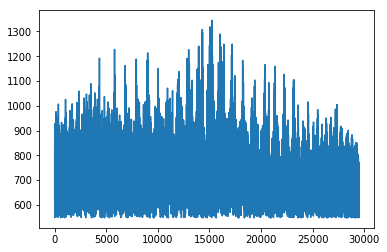

In [27]:
# Display the mean value per voxel, averaged across all scans. 
plt.plot(Y.mean(axis = 0));

In [28]:
# Define the peak voxel as the voxel with the highest mean value across all scans. 
y = Y[:, Y.mean(axis = 0).argmax()]
print('Peak voxel values per scan: ' + str(y))
print('Mean peak voxel value: ' + str(y.mean()))

Peak voxel values per scan: [ 657.  640.  652. ... 1362. 1405. 1431.]
Mean peak voxel value: 1344.889944317065


In [29]:
# Reconstruct a 3D brain image showing the position of the peak voxel. 
peak_voxel_position_array = np.full(Y.shape[1], 0)
peak_voxel_position_array[Y.mean(axis = 0).argmax()] = 1
reconstructed_image = create_coefficients_image(non_nan_indexes, peak_voxel_position_array)

# Find the coordinates of the peak voxel. 
peak_voxel = np.unravel_index(np.nanargmax(reconstructed_image), reconstructed_image.shape)
peak_voxel

(32, 36, 12)

In [30]:
# Check that the reconstructed image contains one value equal to 1, and all the other values equal to 0. 
pd.value_counts(reconstructed_image.flatten())

0.0    29490
1.0        1
dtype: int64

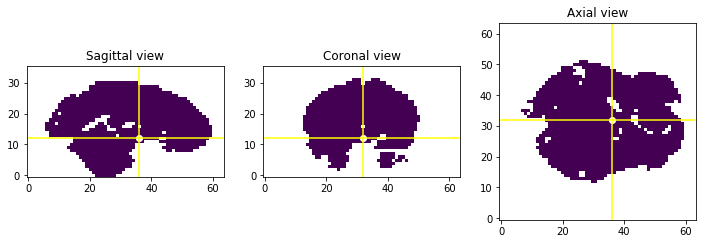

In [31]:
# Display the position of the peak voxel. 
display_voxel_or_cluster_position(peak_voxel, reconstructed_image, reconstructed_image.shape)

In [32]:
# Divide the data into a train set and a test set. 
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)
print('Train set:')
print('X_tr:', X_tr.shape)
print('y_tr:', y_tr.shape)
print('Test set:')
print('X_te:', X_te.shape)
print('y_te:', y_te.shape)

Train set:
X_tr: (2442, 6)
y_tr: (2442,)
Test set:
X_te: (611, 6)
y_te: (611,)


In [33]:
# Baseline model: mean value of the peak voxel in the train set. 
mae_baseline = MAE(y_te, np.mean(y_tr))
mse_baseline = MSE(y_te, np.mean(y_tr))
rss_baseline = RSS(y_te, np.mean(y_tr))
print('MSE baseline:', mse_baseline)
print('MAE baseline:', mae_baseline)
print('RSS baseline:', rss_baseline)

MSE baseline: 11306.991850737879
MAE baseline: 63.63352126118081
RSS baseline: 6908572.020800844


#### Linear regression

In [34]:
# Run a linear regression. 
y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr, coef_lr, rank_lr = regression_model(
    LinearRegression(), X_tr, X_te, y_tr, y_te, return_rank = True)

MSE: 10909.76013870524
MAE: 58.85410930285406
RSS: 6665863.444748902
R^2: 0.03513151130525627


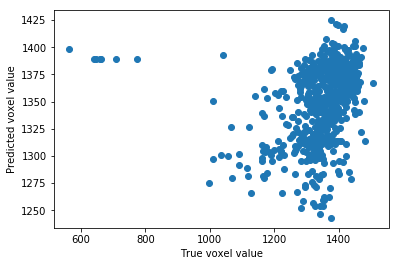

In [35]:
# Compare the true values with the predicted values. 
plt.scatter(y_te, y_pred_lr)
plt.xlabel('True voxel value')
plt.ylabel('Predicted voxel value');

In [36]:
# Compare the rank of the matrix X_tr with its shape. 
print('X_tr rank: ' + str(rank_lr))
print('X_tr shape: ' + str(X_tr.shape))

X_tr rank: 6
X_tr shape: (2442, 6)


In [37]:
# Display the shape of the coefficients from the regression model. 
coef_lr.shape

(6,)

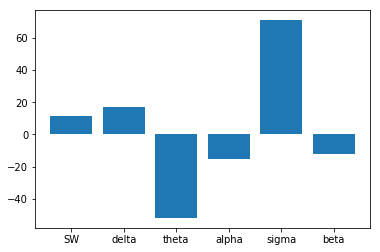

In [38]:
# Display the coefficient values. 
plt.bar(['SW', 'delta', 'theta', 'alpha', 'sigma', 'beta'], coef_lr);

**Result:** The linear regression performs slightly better than the baseline. 

#### Regression with Huber loss

In [39]:
# Run a regression with Huber loss. 
y_pred_huber, mse_huber, mae_huber, rss_huber, r2_huber, coef_huber, _ = regression_model(
    HuberRegressor(epsilon = 1.35), X_tr, X_te, y_tr, y_te)

MSE: 11341.1354811062
MAE: 57.21681996396844
RSS: 6929433.778955888
R^2: -0.003019691781779521


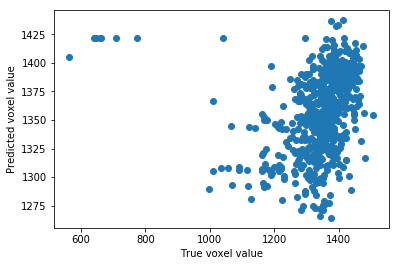

In [40]:
# Compare the true values with the predicted values. 
plt.scatter(y_te, y_pred_huber)
plt.xlabel('True voxel value')
plt.ylabel('Predicted voxel value');

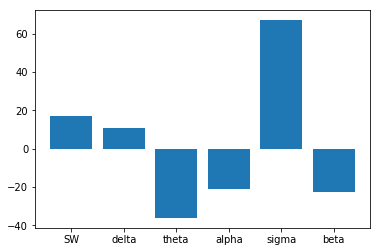

In [41]:
# Display the coefficient values. 
plt.bar(['SW', 'delta', 'theta', 'alpha', 'sigma', 'beta'], coef_huber);

**Result:** The regression with Huber loss performs slightly better than the baseline. 

#### Ridge regression

In [42]:
# Define the range of alpha values to explore for the Ridge regression. 
alpha_values = np.logspace(-8, 8, num = 10)

In [43]:
# Fine-tune a Ridge regression. 
gs_results = fine_tune_ridge_or_lasso(Ridge, X_tr, X_te, y_tr, y_te, alpha_values)

Starting step 0 / 10
Starting step 1 / 10
Starting step 2 / 10
Starting step 3 / 10
Starting step 4 / 10
Starting step 5 / 10
Starting step 6 / 10
Starting step 7 / 10
Starting step 8 / 10
Starting step 9 / 10


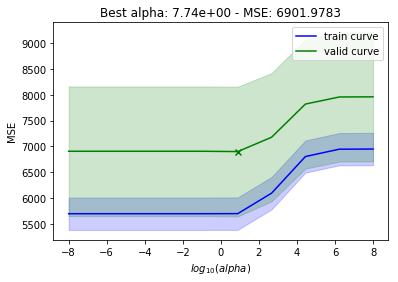

In [44]:
# Display fine-tuning results. 
best_alpha_ridge = display_ridge_or_lasso_fine_tuning(gs_results, alpha_values)

In [45]:
# Run a Ridge regression. 
y_pred_ridge, mse_ridge, mae_ridge, rss_ridge, r2_ridge, coef_ridge, _ = regression_model(
    Ridge(alpha = best_alpha_ridge), X_tr, X_te, y_tr, y_te)

MSE: 10888.247671639281
MAE: 58.70892585455511
RSS: 6652719.327371601
R^2: 0.037034092234821125


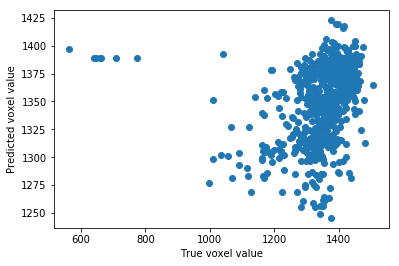

In [46]:
# Compare the true values with the predicted values. 
plt.scatter(y_te, y_pred_ridge)
plt.xlabel('True voxel value')
plt.ylabel('Predicted voxel value');

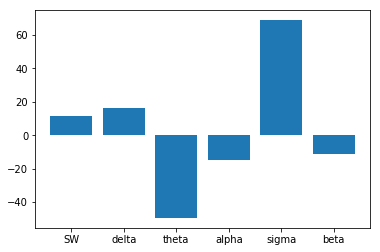

In [47]:
# Display the coefficient values. 
plt.bar(['SW', 'delta', 'theta', 'alpha', 'sigma', 'beta'], coef_ridge);

**Result:** The Ridge regression performs slightly better than the baseline. The results are nearly identifcal to those of the linear regression. 

#### Lasso regression

In [48]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

# Disable ConvergenceWarning error message. 
simplefilter("ignore", category = ConvergenceWarning)

In [49]:
# Define the range of alpha values to explore for the Lasso regression. 
alpha_values = np.logspace(-5, 1, num = 10)

In [50]:
# Fine-tune a Lasso regression. 
gs_results = fine_tune_ridge_or_lasso(Lasso, X_tr, X_te, y_tr, y_te, alpha_values)

Starting step 0 / 10
Starting step 1 / 10
Starting step 2 / 10
Starting step 3 / 10
Starting step 4 / 10
Starting step 5 / 10
Starting step 6 / 10
Starting step 7 / 10
Starting step 8 / 10
Starting step 9 / 10


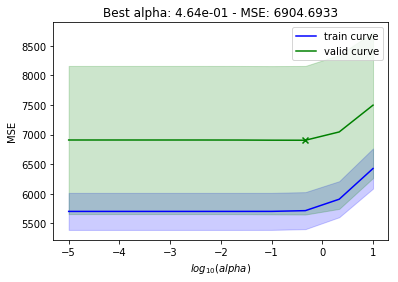

In [51]:
# Display fine-tuning results. 
best_alpha_lasso = display_ridge_or_lasso_fine_tuning(gs_results, alpha_values)

In [52]:
# Run a Lasso regression. 
y_pred_lasso, mse_lasso, mae_lasso, rss_lasso, r2_lasso, coef_lasso, _ = regression_model(
    Lasso(alpha = best_alpha_lasso), X_tr, X_te, y_tr, y_te)

MSE: 10831.366342291745
MAE: 58.530999199711836
RSS: 6617964.835140256
R^2: 0.042064725501247735


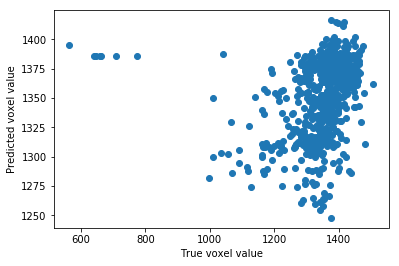

In [53]:
# Compare the true values with the predicted values. 
plt.scatter(y_te, y_pred_lasso)
plt.xlabel('True voxel value')
plt.ylabel('Predicted voxel value');

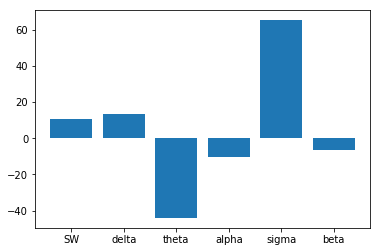

In [54]:
# Display the coefficient values. 
plt.bar(['SW', 'delta', 'theta', 'alpha', 'sigma', 'beta'], coef_lasso);

**Result:** The Lasso regression performs slightly better than the baseline. The results are nearly identifcal to those of the linear regression. 

In [55]:
# Save the results into a .npz file. 
np.savez(results_path + 'regression_with_EEG_predictors_single_subject.npz', 
         
         # Example subject. 
         subject_index = subject_index, 
         
         # Peak voxel. 
         peak_voxel = peak_voxel, 
         reconstructed_image = reconstructed_image, 
         
         # Baseline. 
         rss_baseline = rss_baseline,
         
         # Linear regression. 
         rss_lr = rss_lr, 
         r2_lr = r2_lr, 
         coef_lr = coef_lr, 
         
         # Regression with Huber loss. 
         rss_huber = rss_huber, 
         r2_huber = r2_huber, 
         coef_huber = coef_huber,
         
         # Ridge regression. 
         rss_ridge = rss_ridge, 
         r2_ridge = r2_ridge, 
         coef_ridge = coef_ridge, 
         
         # Lasso regression. 
         rss_lasso = rss_lasso, 
         r2_lasso = r2_lasso, 
         coef_lasso = coef_lasso)

### **3.2 Targets: all the voxels**

In the following cells, we **fit and compute predictions from a linear regression** for a single subject, using successively all the voxels as targets. 

In [56]:
# Define an example subject. 
subject_index = subjects[1] # Warning: the first subject has inconsistent length of EEG and fMRI data. 

# Define the voxel size rescaling factor to be used. 1: original voxel size. 2: factor 2. 3: factor 3. 
rescaling_factor = 1

In [57]:
# Define the number of voxels. 
nb_voxels = formatted_predictors_fMRI[subject_index].shape[1]
nb_voxels

29491

In [58]:
# Create a dictionary and two NumPy arrays to store the results. 
lr_all_voxels_results = dict()
lr_all_voxels_r2 = np.zeros(nb_voxels)
lr_all_voxels_sum_coef = np.zeros(6)

# Define the features and targets variables. 
X = predictors_EEG[subject_index].iloc[:, 2:8].values
if rescaling_factor == 1:
    Y = formatted_predictors_fMRI[subject_index]
    non_nan_indexes = non_nan_indexes_fMRI[subject_index]
elif rescaling_factor == 2:
    Y = formatted_predictors_fMRI_r2[subject_index]
    non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
elif rescaling_factor == 3:
    Y = formatted_predictors_fMRI_r3[subject_index]
    non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]

# Iterate through all voxels. 
for voxel_index in range(nb_voxels):
    
    # Display current step. 
    nb_steps = 10
    if voxel_index % int(nb_voxels / nb_steps) == 0:
        print('Starting step: ' + str(int((voxel_index + 1) // (nb_voxels / nb_steps))) + ' / 10')
    
    # Define the target voxel. 
    y = Y[:, voxel_index]
    
    # Divide the data into a train set and a test set. 
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)
    
    # Baseline model: mean value of the alpha band in the train set. 
    rss_baseline = RSS(y_te, np.mean(y_tr))
    
    # Run a linear regression. 
    y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr, coef_lr, rank_lr = regression_model(
        LinearRegression(), X_tr, X_te, y_tr, y_te, display_results = False, return_rank = True)
    
    # Store the results in the dictionary and the two NumPy arrays. 
    lr_all_voxels_results[voxel_index] = {'y_te': y_te, 
                                          'y_pred_lr': y_pred_lr,
                                          'coef_lr': coef_lr,
                                          'rss_baseline': rss_baseline,
                                          'rss_lr': rss_lr,
                                          'r2_lr': r2_lr}
    lr_all_voxels_r2[voxel_index] = r2_lr
    lr_all_voxels_sum_coef += coef_lr

Starting step: 0 / 10
Starting step: 1 / 10
Starting step: 2 / 10
Starting step: 3 / 10
Starting step: 4 / 10
Starting step: 5 / 10
Starting step: 6 / 10
Starting step: 7 / 10
Starting step: 8 / 10
Starting step: 9 / 10
Starting step: 10 / 10


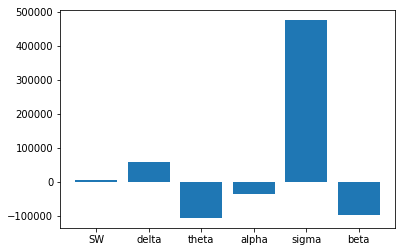

In [59]:
# Display the sum of the coefficient values across all voxels. 
plt.bar(['SW', 'delta', 'theta', 'alpha', 'sigma', 'beta'], lr_all_voxels_sum_coef);

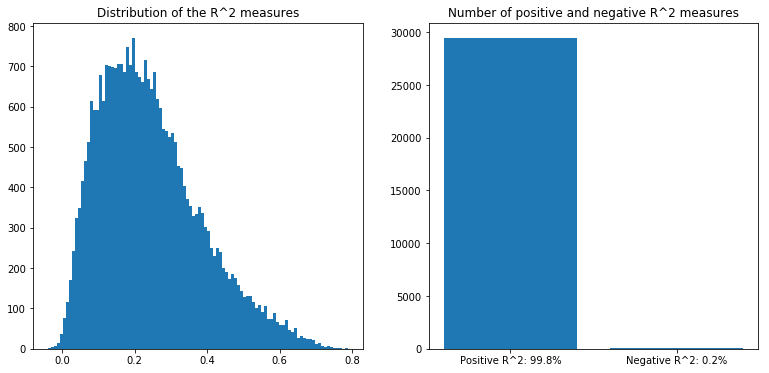

In [60]:
# Display a histogram of the predictability values of all voxels. 
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 6))
axes[0].hist(lr_all_voxels_r2, bins = 100)
axes[0].set_title('Distribution of the R^2 measures')
axes[1].bar([1, 2], [np.sum(lr_all_voxels_r2 > 0), np.sum(lr_all_voxels_r2 < 0)])
axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(['Positive R^2: ' + str(np.round(100 * np.sum(lr_all_voxels_r2 > 0) / len(lr_all_voxels_r2), 2)) + '%',
                         'Negative R^2: ' + str(np.round(100 * np.sum(lr_all_voxels_r2 < 0) / len(lr_all_voxels_r2), 2)) + '%'])
axes[1].set_title('Number of positive and negative R^2 measures');

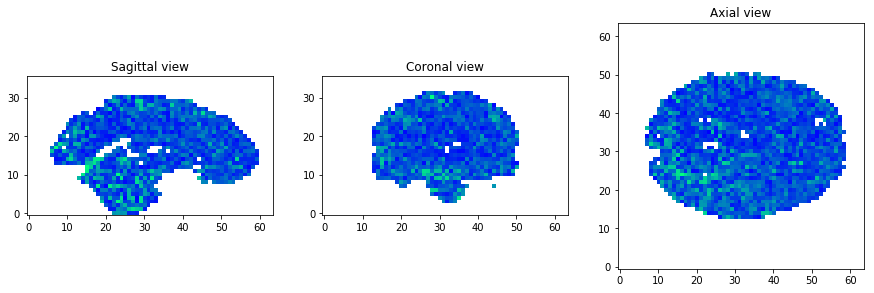

In [61]:
# Reconstruct a 3D brain image showing the R^2 measure for each voxel. 
r2_image_lr = create_coefficients_image(non_nan_indexes, lr_all_voxels_r2)

# Display the R^2 for each voxel at the middle section coordinates. 
middle_coord = middle_sections(r2_image_lr)
display_fMRI_image(r2_image_lr[:, :, :, np.newaxis], middle_coord, colormap = 'winter')

**Result:** The linear regression performs better than the baseline for almost all the voxels, as we can see in the distribution of the R^2 measures. In the predictability map above, voxels with low and high predictability seem to be distributed across the whole brain. Still, after some visual inspection, there seem to be some clusters of voxels with similar R^2 measures. 

## **4. Regression on all subjects**

### **4.1 Target: the peak voxel**

In the following cells, we **fit and compute predictions from a linear regression** for all the subjects, using the peak voxel of each subject as the target. We must remember that the fMRI images are not normalized into a common template. As a consequence, most of the time, the peak voxel from one subject will not be at the same position as the peak voxel from another subject. The only thing in common is that we are dealing, for each subject, with the voxel showing the highest mean value across all scans. 

In [62]:
# Define the voxel size rescaling factor to be used. 1: original voxel size. 2: factor 2. 3: factor 3. 
rescaling_factor = 1

In [63]:
# Create a dictionary and two NumPy arrays to store the results. 
lr_all_subjects_results = dict()
lr_all_subjects_r2 = np.zeros(len(subjects[1:]))
lr_all_subjects_sum_coef = np.zeros(6)
counter = 0

# Iterate through all subjects. 
for subject_index in subjects[1:]: # Warning: the first subject has inconsistent length of EEG and fMRI data. 
    
    # Display current step. 
    print('Starting subject: ' + subject_index)
    
    # Define the features and target variables. 
    X = predictors_EEG[subject_index].iloc[:, 2:8].values
    if rescaling_factor == 1:
        Y = formatted_predictors_fMRI[subject_index]
        non_nan_indexes = non_nan_indexes_fMRI[subject_index]
    elif rescaling_factor == 2:
        Y = formatted_predictors_fMRI_r2[subject_index]
        non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
    elif rescaling_factor == 3:
        Y = formatted_predictors_fMRI_r3[subject_index]
        non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
        
    # Define the peak voxel as the voxel with the highest mean value across all scans. 
    y = Y[:, Y.mean(axis = 0).argmax()]
    
    # Divide the data into a train set and a test set. 
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)
    
    # Baseline model: mean value of the alpha band in the train set. 
    rss_baseline = RSS(y_te, np.mean(y_tr))
    
    # Run a linear regression. 
    y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr, coef_lr, rank_lr = regression_model(
        LinearRegression(), X_tr, X_te, y_tr, y_te, return_rank = True)
    print()
    
    # Reconstruct a 3D brain image showing the position of the peak voxel. 
    middle_coord = middle_sections(non_nan_indexes)
    peak_voxel_position_array = np.full(Y.shape[1], 0)
    peak_voxel_position_array[Y.mean(axis = 0).argmax()] = 1
    reconstructed_image = create_coefficients_image(non_nan_indexes, peak_voxel_position_array)

    # Find the coordinates of the peak voxel. 
    peak_voxel = np.unravel_index(np.nanargmax(reconstructed_image), reconstructed_image.shape)
    
    # Store the results in the dictionary and the two NumPy arrays. 
    lr_all_subjects_results[subject_index] = {'y_te': y_te, 
                                              'y_pred_lr': y_pred_lr,
                                              'coef_lr': coef_lr,
                                              'reconstructed_image': reconstructed_image,
                                              'middle_coord': middle_coord,
                                              'peak_voxel': peak_voxel,
                                              'rss_baseline': rss_baseline,
                                              'rss_lr': rss_lr,
                                              'r2_lr': r2_lr}
    lr_all_subjects_r2[counter] = r2_lr
    lr_all_subjects_sum_coef += coef_lr
    
    # Increment. 
    counter += 1

Starting subject: sub-02
MSE: 6347.473980673615
MAE: 53.20205829605884
RSS: 3878306.602191579
R^2: 0.11302962798428395

Starting subject: sub-03
MSE: 41408.081239857514
MAE: 163.61303012297958
RSS: 21532202.24472591
R^2: 0.15140853359789608

Starting subject: sub-04
MSE: 1207.1644280593914
MAE: 26.70681207942201
RSS: 567367.281187914
R^2: 0.2418458735174418

Starting subject: sub-05
MSE: 85602.4723313707
MAE: 240.01759957699937
RSS: 61462575.13392417
R^2: 0.009516208724375641

Starting subject: sub-06
MSE: 59138.63437313451
MAE: 189.91511952558494
RSS: 35719735.16137324
R^2: 0.04001472596685807

Starting subject: sub-07
MSE: 59594.208923959886
MAE: 187.05783965171668
RSS: 31406148.10292686
R^2: 0.11085157836647797

Starting subject: sub-08
MSE: 47506.5462579881
MAE: 189.86796068658586
RSS: 30784241.97517629
R^2: 0.02140614203369906

Starting subject: sub-09
MSE: 32247.91980515897
MAE: 152.50077580648977
RSS: 15833728.624333054
R^2: 0.056820125518509235

Starting subject: sub-10
MSE: 15

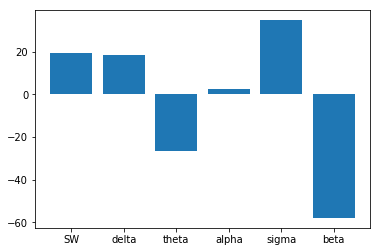

In [64]:
# Display the mean of the coefficient values for each EEG predictor, averaging all subjects. 
plt.bar(['SW', 'delta', 'theta', 'alpha', 'sigma', 'beta'], (lr_all_subjects_sum_coef / len(subjects[1:])) );

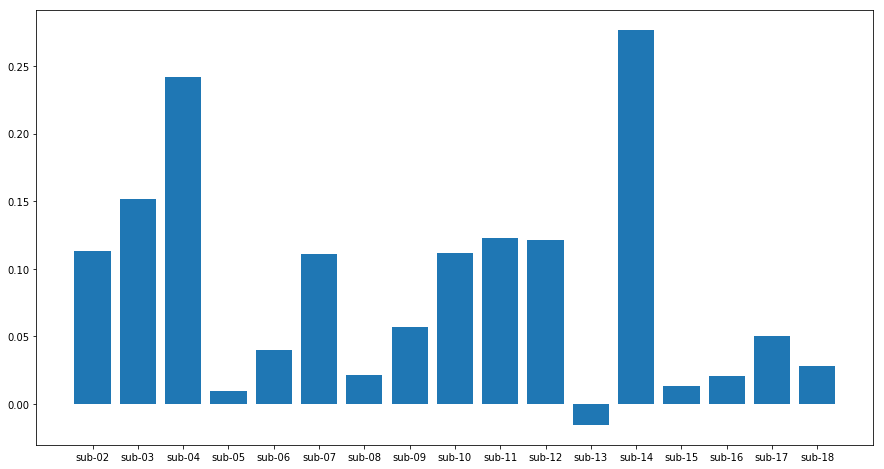

In [65]:
# Display the R^2 measure for the peak voxel of all subjects. 
plt.figure(figsize = (15, 8))
plt.bar(subjects[1:], lr_all_subjects_r2);

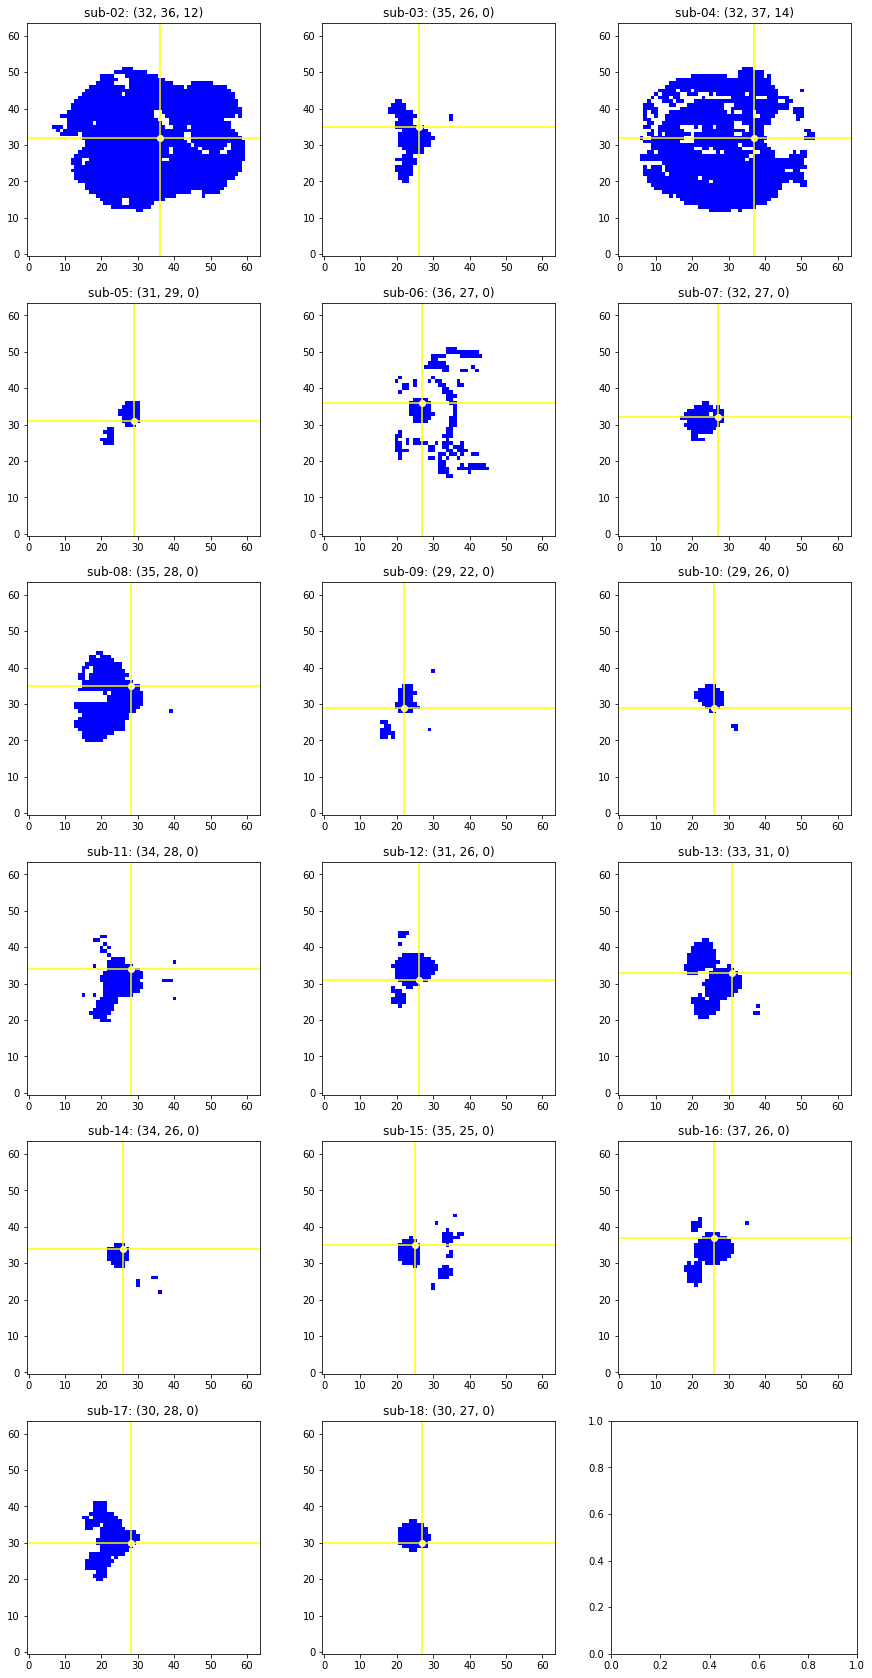

In [66]:
# Display the position of the peak voxel for all subjects. 
fig, axes = plt.subplots(nrows = 6, ncols = 3, figsize = (15, 30))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects[1:]: # Warning: the first subject has inconsistent length of EEG and fMRI data. 
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Retrieve the reconstructed image and the peak voxel index. 
    reconstructed_image = lr_all_subjects_results[subject_index]['reconstructed_image']
    peak_voxel = lr_all_subjects_results[subject_index]['peak_voxel']
    
    # Display the graphs. 
    middle_coord = lr_all_subjects_results[subject_index]['middle_coord']
    axes[row_index, column_index].imshow(reconstructed_image[:, :, peak_voxel[2]], origin = 'lower', cmap = 'winter')
    axes[row_index, column_index].axhline(peak_voxel[0], 0, reconstructed_image.shape[1], color = 'yellow') # Horizontal line through coronal view. 
    axes[row_index, column_index].axvline(peak_voxel[1], 0, reconstructed_image.shape[0], color = 'yellow') # Vertical line through sagittal view. 
    axes[row_index, column_index].scatter(peak_voxel[1], peak_voxel[0], marker = 'o', c = 'white')
    axes[row_index, column_index].set_title(subject_index + ': ' + str(peak_voxel))
    
    # Increment. 
    counter += 1

**Result:** The linear regression performs better than the baseline for most subjects, but sometimes the R^2 measure is very low, and sometimes it is more significant. As expected, the position of the peak voxel varies among the subjects. 

### **4.2 Targets: all the voxels**

In the following cells, we **fit and compute predictions from a linear regression** for all the subjects and all the voxels. 

In [67]:
# Create dictionaries to store the results at the subject level. 
lr_results_at_subject_level = dict()
r2_images_per_subject = dict()
middle_coord_per_subject = dict()

# Create two NumPy arrays to store the results at the subject and voxel levels. 
lr_all_subjects_all_voxels_r2 = np.zeros((len(subjects[1:]), nb_voxels))
lr_all_subjects_all_voxels_sum_coef = np.zeros((len(subjects[1:]), 6))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects[1:]: # Warning: the first subject has inconsistent length of EEG and fMRI data. 
    
    # Display current step. 
    print('Starting subject: ' + subject_index)
    
    # Create a dictionary to store the results at the voxel level. 
    lr_results_at_voxel_level = dict()
    
    # Define the features and target variables. 
    X = predictors_EEG[subject_index].iloc[:, 2:8].values
    if rescaling_factor == 1:
        Y = formatted_predictors_fMRI[subject_index]
        non_nan_indexes = non_nan_indexes_fMRI[subject_index]
    elif rescaling_factor == 2:
        Y = formatted_predictors_fMRI_r2[subject_index]
        non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
    elif rescaling_factor == 3:
        Y = formatted_predictors_fMRI_r3[subject_index]
        non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
    
    # Define the number of voxels. 
    nb_voxels = Y.shape[1]
    
    # Iterate through all voxels. 
    for voxel_index in range(nb_voxels):

        # Define the target voxel. 
        y = Y[:, voxel_index]

        # Divide the data into a train set and a test set. 
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)

        # Baseline model: mean value of the alpha band in the train set. 
        rss_baseline = RSS(y_te, np.mean(y_tr))

        # Run a linear regression. 
        y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr, coef_lr, rank_lr = regression_model(
            LinearRegression(), X_tr, X_te, y_tr, y_te, display_results = False, return_rank = True)
        
        # Store the results in the dictionary and the two NumPy arrays. 
        lr_results_at_voxel_level[voxel_index] = {'y_te': y_te, 
                                                  'y_pred_lr': y_pred_lr,
                                                  'coef_lr': coef_lr,
                                                  'rss_baseline': rss_baseline,
                                                  'rss_lr': rss_lr,
                                                  'r2_lr': r2_lr}
        lr_all_subjects_all_voxels_r2[counter, voxel_index] = r2_lr
        lr_all_subjects_all_voxels_sum_coef[counter, :] += coef_lr
    
    # Reconstruct a 3D brain image showing the R^2 measure for each voxel. 
    r2_image_lr = create_coefficients_image(non_nan_indexes, lr_all_subjects_all_voxels_r2[counter, :])
    middle_coord = middle_sections(r2_image_lr)
    
    # Store the results in the dictionaries. 
    lr_results_at_subject_level[subject_index] = lr_results_at_voxel_level
    r2_images_per_subject[subject_index] = r2_image_lr
    middle_coord_per_subject[subject_index] = middle_coord
    
    # Increment. 
    counter += 1

Starting subject: sub-02
Starting subject: sub-03
Starting subject: sub-04
Starting subject: sub-05
Starting subject: sub-06
Starting subject: sub-07
Starting subject: sub-08
Starting subject: sub-09
Starting subject: sub-10
Starting subject: sub-11
Starting subject: sub-12
Starting subject: sub-13
Starting subject: sub-14
Starting subject: sub-15
Starting subject: sub-16
Starting subject: sub-17
Starting subject: sub-18


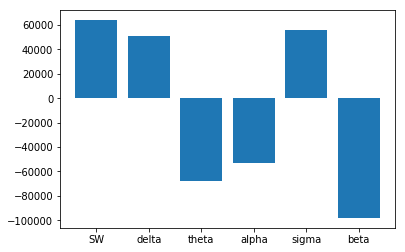

In [68]:
# Display the sum of the coefficient values for each EEG predictor, averaging all subjects. 
plt.bar(['SW', 'delta', 'theta', 'alpha', 'sigma', 'beta'], lr_all_subjects_all_voxels_sum_coef.mean(axis = 0));

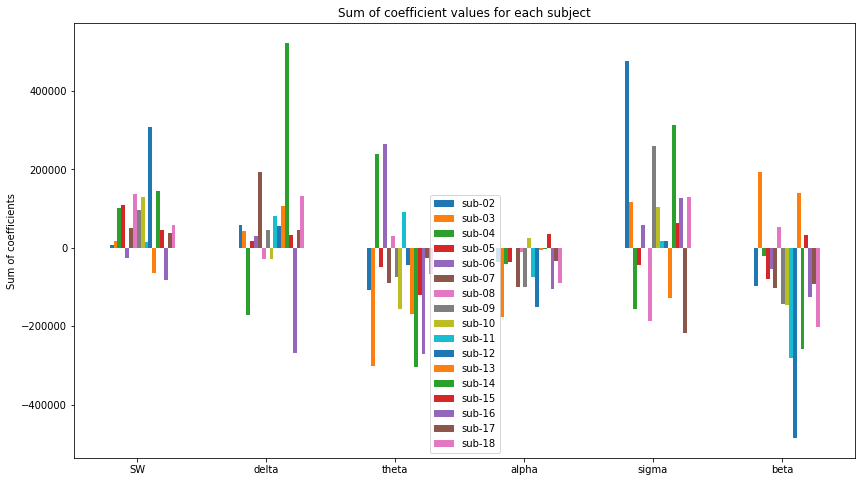

In [69]:
# Display the sum of the coefficient values for all subjects. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (14, 8))
x_coord = np.array(range(0, 6))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects[1:]:
    axes.bar(x_coord, lr_all_subjects_all_voxels_sum_coef[counter, :], width = 0.03, label = subject_index)
    x_coord = x_coord + 0.03
    counter += 1

# Add labels and title. 
axes.set_xticks(np.array(range(0, 6)) + 0.2)
axes.set_xticklabels(['SW', 'delta', 'theta', 'alpha', 'sigma', 'beta'])
axes.set_ylabel('Sum of coefficients')
axes.legend()
axes.set_title('Sum of coefficient values for each subject');

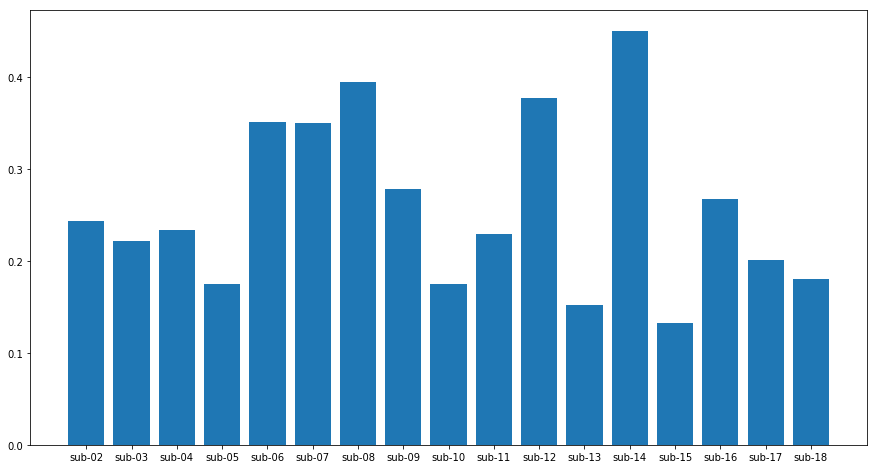

In [70]:
# Display the mean R^2 measure for all subjects, averaging all voxels. 
plt.figure(figsize = (15, 8))
plt.bar(subjects[1:], lr_all_subjects_all_voxels_r2.mean(axis = 1));

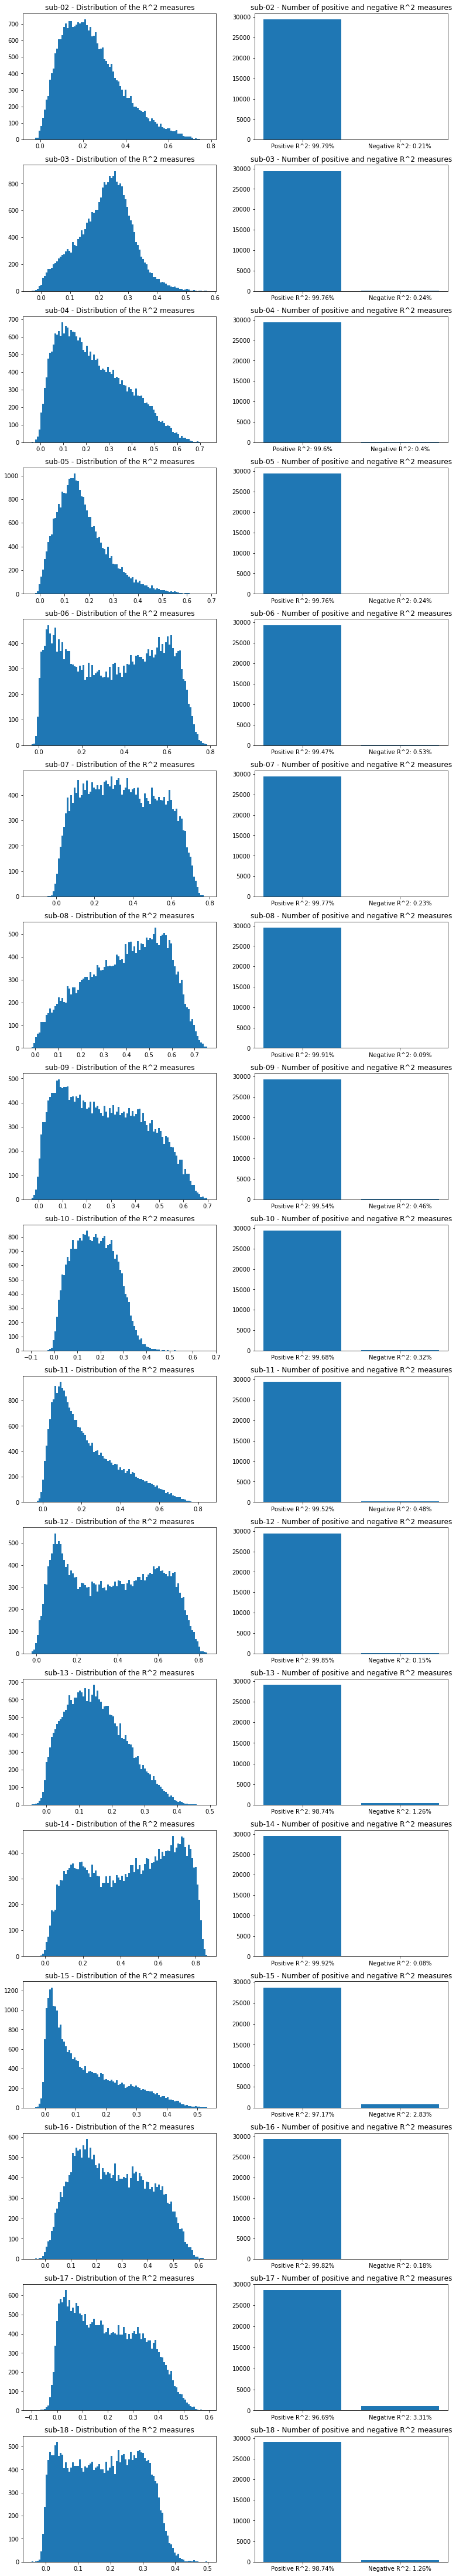

In [71]:
# Display a histogram of the predictability values of all voxels. 
fig, axes = plt.subplots(nrows = len(subjects[1:]), ncols = 2, figsize = (13, 80))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects[1:]:
    axes[counter, 0].hist(lr_all_subjects_all_voxels_r2[counter, :], bins = 100)
    axes[counter, 0].set_title(subject_index + ' - Distribution of the R^2 measures')
    axes[counter, 1].bar([1, 2], [np.sum(lr_all_subjects_all_voxels_r2[counter, :] > 0), np.sum(lr_all_subjects_all_voxels_r2[counter, :] < 0)])
    axes[counter, 1].set_xticks([1, 2])
    axes[counter, 1].set_xticklabels(['Positive R^2: ' + str(np.round(100 * np.sum(lr_all_subjects_all_voxels_r2[counter, :] > 0) / len(lr_all_subjects_all_voxels_r2[counter, :]), 2)) + '%',
                             'Negative R^2: ' + str(np.round(100 * np.sum(lr_all_subjects_all_voxels_r2[counter, :] < 0) / len(lr_all_subjects_all_voxels_r2[counter, :]), 2)) + '%'])
    axes[counter, 1].set_title(subject_index + ' - Number of positive and negative R^2 measures');
    
    # Increment. 
    counter += 1

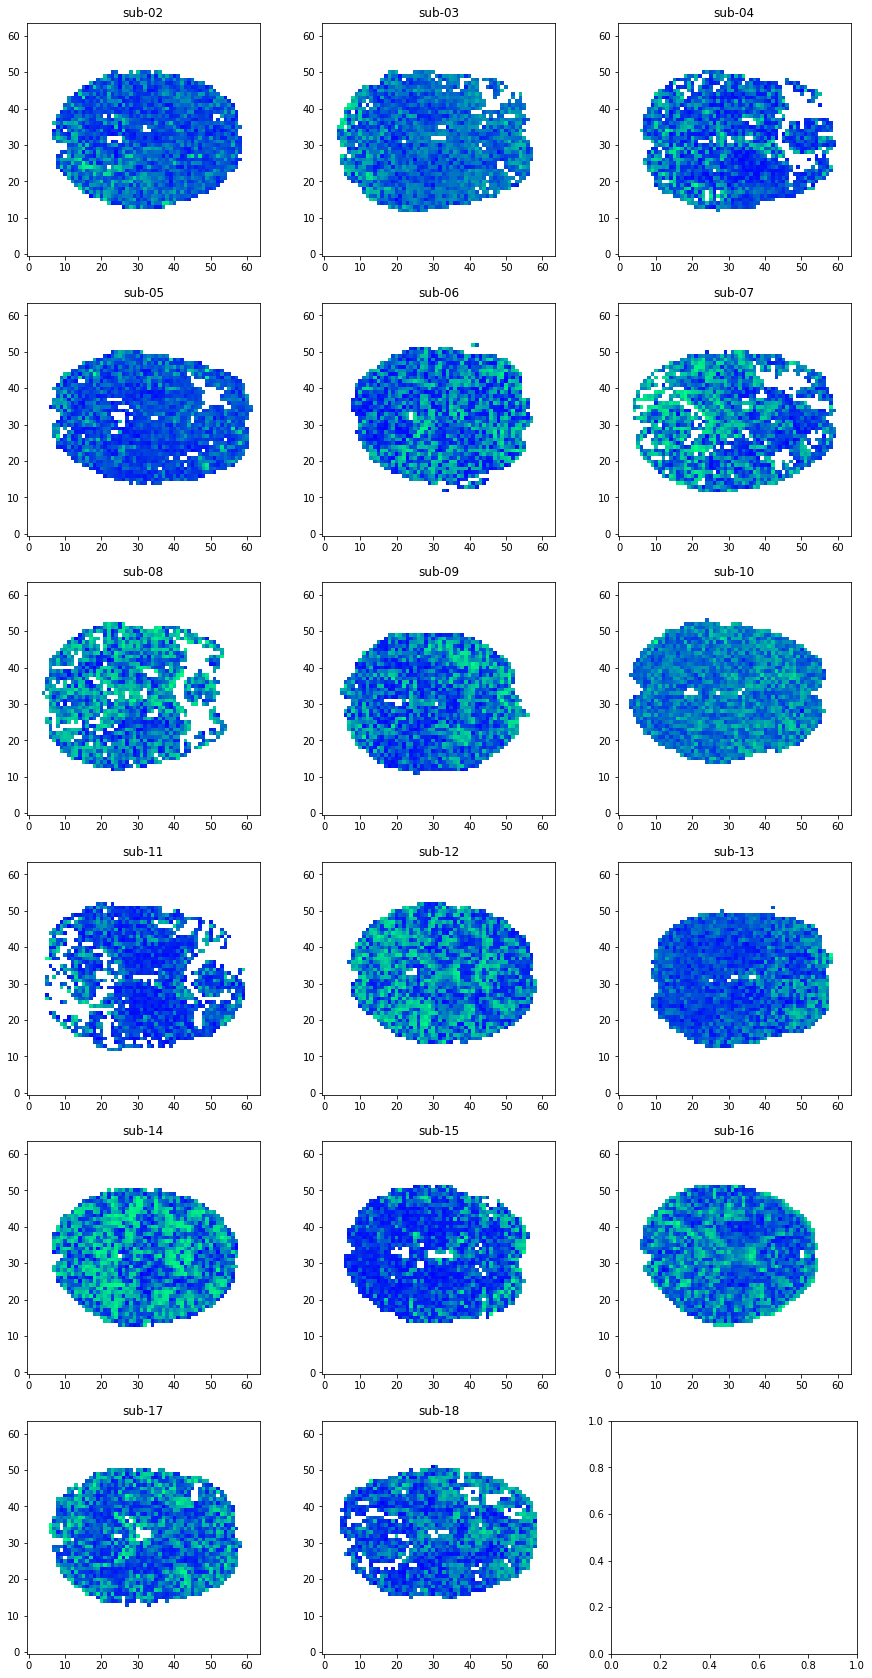

In [72]:
# Display the R^2 measure for each voxel at the middle section coordinates of the axial view. 
fig, axes = plt.subplots(nrows = 6, ncols = 3, figsize = (15, 30))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects[1:]:
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Retrieve and display the R^2 image. 
    r2_image_lr = r2_images_per_subject[subject_index]
    middle_coord = middle_coord_per_subject[subject_index]
    axes[row_index, column_index].imshow(r2_image_lr[:, :, middle_coord[2]], origin = 'lower', cmap = 'winter')
    axes[row_index, column_index].set_title(subject_index);
    
    # Increment. 
    counter += 1

**Result:** When averaging the R^2 measures of all the voxels, the linear regression performs better than the baseline for all the subjects. The proportion of voxels with a negative R^2 measure is always quite low. We can see some tendencies regarding the coefficients associated to the different EEG frequency bands, but overall there is a strong inter-subject variability. In the predictability maps, we can again notice some clusters of voxels with similar R^2 measures. Since the brain images are not normalized into a common template, we cannot draw any conclusion regarding specific brain regions. Still, it appears that the BOLD signal from some regions may be relatively predictable by the EEG frequency bands, while in other regions, this signal remains more unpredictable. 

In [73]:
# Save the results into a Pickle file. 
with open(results_path + 'regression_with_EEG_predictors.p', 'wb') as file:
    pickle.dump(lr_results_at_subject_level, file)

In [74]:
# Create a dictionary to hold all the information related to the predictability maps. 
r2_brain_maps = {'r2_images_per_subject': r2_images_per_subject, 'middle_coord_per_subject': middle_coord_per_subject}

# Save the results into a Pickle file. 
with open(results_path + 'regression_with_EEG_predictors_brain_maps.p', 'wb') as file:
    pickle.dump(r2_brain_maps, file)

In [75]:
# Save the results into a .npz file. 
np.savez(results_path + 'regression_with_EEG_predictors.npz', 
         
         # Results for all subjects and all voxels. 
         lr_all_subjects_all_voxels_r2 = lr_all_subjects_all_voxels_r2,
         lr_all_subjects_all_voxels_sum_coef = lr_all_subjects_all_voxels_sum_coef)